In [1]:
print("yo")
import torch
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

yo
cuda:0


In [2]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.metrics import precision_score,recall_score,accuracy_score

path = '.'
import os
import shutil

In [3]:
dataParts = ["test","train","valid"]

for dataPart in dataParts:
    dirs = os.listdir(f'{path}/Data/{dataPart}')
    print(dataPart,dirs)
    for dirName in dirs:
        if dirName[0] == ".":
            print(f'{path}/Data/{dataPart}/{dirName}')
            shutil.rmtree(f'{path}/Data/{dataPart}/{dirName}')

transformer = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(15,shear=0.2,translate=(0.1,0.1),scale=(0.8,1.2)),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.Resize((224,224),interpolation=torchvision.transforms.InterpolationMode.NEAREST),
    torchvision.transforms.PILToTensor()
])

train_datagen = torchvision.datasets.ImageFolder(f'{path}/Data/train',transform=transformer)
val_datagen = torchvision.datasets.ImageFolder(f'{path}/Data/valid',transform=transformer)
test_datagen = torchvision.datasets.ImageFolder(f'{path}/Data/test',transform=transformer)
print(train_datagen)
print(val_datagen)
print(test_datagen)

from collections import Counter
print(dict(Counter(train_datagen.targets)),len(train_datagen.targets))
print(dict(Counter(val_datagen.targets)),len(val_datagen.targets))
print(dict(Counter(test_datagen.targets)),len(test_datagen.targets))

batch_size = 16

train_data = torch.utils.data.DataLoader(train_datagen, batch_size=batch_size, shuffle=True)
val_data = torch.utils.data.DataLoader(val_datagen, batch_size=batch_size, shuffle=True)
test_data = torch.utils.data.DataLoader(test_datagen, batch_size=batch_size, shuffle=True)

test ['large', 'squam', 'normal', 'ac']
train ['large', 'squam', 'normal', 'ac']
valid ['large', 'squam', 'normal', 'ac']
Dataset ImageFolder
    Number of datapoints: 613
    Root location: ./Data/train
    StandardTransform
Transform: Compose(
               RandomAffine(degrees=[-15.0, 15.0], translate=(0.1, 0.1), scale=(0.8, 1.2), shear=[-0.2, 0.2])
               RandomHorizontalFlip(p=0.5)
               Resize(size=(224, 224), interpolation=nearest, max_size=None, antialias=None)
               PILToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 72
    Root location: ./Data/valid
    StandardTransform
Transform: Compose(
               RandomAffine(degrees=[-15.0, 15.0], translate=(0.1, 0.1), scale=(0.8, 1.2), shear=[-0.2, 0.2])
               RandomHorizontalFlip(p=0.5)
               Resize(size=(224, 224), interpolation=nearest, max_size=None, antialias=None)
               PILToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 315
    R

In [4]:
net = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True)

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
net.outc = Identity()

class new_layers(nn.Module):
    def __init__(self):
        super(new_layers, self).__init__()
        self.fc = torch.nn.Linear(64,4)
        self.softmax = torch.nn.Softmax(dim=-1)
        
    def forward(self,x):
        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        x = torch.squeeze(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x
model = nn.Sequential(net, new_layers()).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

epochs = 30
n_train = len(train_datagen)
from tqdm import tqdm
train_losses = []
train_accs = []
train_precision = []
train_recall = []
val_losses = []
val_accs = []
val_precision = []
val_recall = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    images = 0
    train_true = []
    train_pred = []
    with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
        for batch,target in train_data:
            pred = model(batch.float().to(device))
            train_pred += torch.argmax(pred.detach(),-1).tolist()
            train_true += target.tolist()
            loss = criterion(pred, target.to(device))
            epoch_loss += loss.item()*batch.shape[0]
            images += batch.shape[0]
            pbar.set_postfix(**{'loss (batch)': loss.item()})
            optim.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(model.parameters(), 0.1)
            optim.step()
            pbar.update(batch.shape[0])
    train_losses.append(epoch_loss/images)
    train_accs.append(accuracy_score(train_true,train_pred))
    train_precision.append(precision_score(train_true,train_pred,average="macro",zero_division=1))
    train_recall.append(recall_score(train_true,train_pred,average="macro"))
    model.eval()
    val_loss = 0
    images = 0
    val_true = []
    val_pred = []
    for batch,target in val_data:
        pred = model(batch.float().to(device))
        val_pred += torch.argmax(pred.detach(),-1).tolist()
        val_true += target.tolist()
        loss = criterion(pred, target.to(device))
        val_loss += loss.item()*batch.shape[0]
        images += batch.shape[0]
    val_losses.append(val_loss/images)
    val_accs.append(accuracy_score(val_true,val_pred))
    val_precision.append(precision_score(val_true,val_pred,average="macro",zero_division=1))
    val_recall.append(recall_score(val_true,val_pred,average="macro"))

Downloading: "https://github.com/milesial/Pytorch-UNet/archive/master.zip" to /home/ec2-user/.cache/torch/hub/master.zip
Downloading: "https://github.com/milesial/Pytorch-UNet/releases/download/v3.0/unet_carvana_scale0.5_epoch2.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/unet_carvana_scale0.5_epoch2.pth


  0%|          | 0.00/118M [00:00<?, ?B/s]

Epoch 30/30: 100%|██████████| 613/613 [00:24<00:00, 25.42img/s, loss (batch)=1.14] 


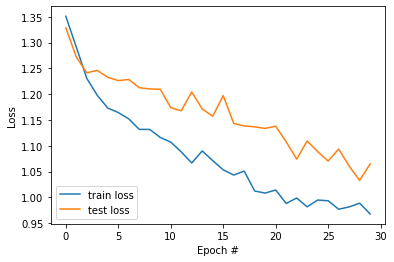

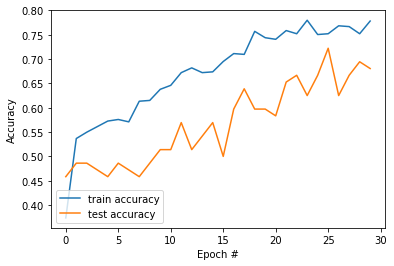

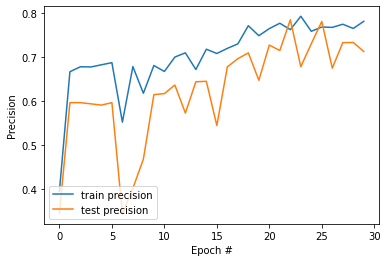

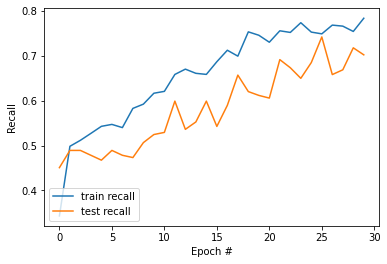

In [6]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label="train loss")
plt.plot(val_losses,label="test loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc='lower left')
plt.show()
plt.plot(train_accs,label="train accuracy")
plt.plot(val_accs,label="test accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc='lower left')
plt.show()
plt.plot(train_precision,label="train precision")
plt.plot(val_precision,label="test precision")
plt.xlabel("Epoch #")
plt.ylabel("Precision")
plt.legend(loc='lower left')
plt.show()
plt.plot(train_recall,label="train recall")
plt.plot(val_recall,label="test recall")
plt.xlabel("Epoch #")
plt.ylabel("Recall")
plt.legend(loc='lower left')
plt.show()

In [71]:
model.eval()
val_true = []
val_pred = []
for batch,target in val_data:
    pred = model(batch.float().to(device))
    val_pred += torch.argmax(pred.detach(),-1).tolist()
    val_true += target.tolist()
    loss = criterion(pred, target.to(device))
    val_loss += loss.item()*batch.shape[0]
    images += batch.shape[0]
print("Val:")
print(f"Loss: {val_loss/images} Accuracy: {accuracy_score(val_true,val_pred)} \
Precision: {precision_score(val_true,val_pred,average='macro',zero_division=1)} Recall {recall_score(val_true,val_pred,average='macro')}")

val_true = []
val_pred = []
for batch,target in train_data:
    pred = model(batch.float().to(device))
    val_pred += torch.argmax(pred.detach(),-1).tolist()
    val_true += target.tolist()
    loss = criterion(pred, target.to(device))
    val_loss += loss.item()*batch.shape[0]
    images += batch.shape[0]
print("Train:")
print(f"Loss: {val_loss/images} Accuracy: {accuracy_score(val_true,val_pred)} \
Precision: {precision_score(val_true,val_pred,average='macro',zero_division=1)} Recall {recall_score(val_true,val_pred,average='macro')}")

val_true = []
val_pred = []
for batch,target in test_data:
    pred = model(batch.float().to(device))
    val_pred += torch.argmax(pred.detach(),-1).tolist()
    val_true += target.tolist()
    loss = criterion(pred, target.to(device))
    val_loss += loss.item()*batch.shape[0]
    images += batch.shape[0]
print("Test:")
print(f"Loss: {val_loss/images} Accuracy: {accuracy_score(val_true,val_pred)} \
Precision: {precision_score(val_true,val_pred,average='macro',zero_division=1)} Recall {recall_score(val_true,val_pred,average='macro')}")

Val:
Loss: 1.2227063046561346 Accuracy: 0.5 Precision: 0.847457627118644 Recall 0.5
Train:
Loss: 1.153553093282833 Accuracy: 0.5497553017944535 Precision: 0.8333493651404387 Recall 0.49190055440055436
Test:
Loss: 1.1599437598861866 Accuracy: 0.5492063492063493 Precision: 0.8645038167938931 Recall 0.49537037037037035


In [74]:
print(train_pred)

[0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 